In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



We will use Keras-BERT and adapters available in keras for finetuning.


In [2]:
import codecs
import tensorflow as tf
from tqdm import tqdm
from chardet import detect
import keras
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
# from google.colab import drive



C:\Users\Bohne\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


**PARAMETERS**

In [3]:

SEQ_LEN = 128
BATCH_SIZE = 20
EPOCHS = 7
LR = 1e-4

**Path to the pre trained model of BERT.**

In [38]:

import os
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')


**Loading Pretrained BERT model.**

In [39]:
model = load_trained_model_from_checkpoint(
      config_path,
      checkpoint_path,
      training=True,
      trainable=True,
      seq_len=SEQ_LEN,
  )

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

**Extracting token dictionary from vocab of pretrained model to refer for input we will be using.**

In [7]:
import codecs
from keras_bert import Tokenizer
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
        
# print(token_dict)

**Open dataset.**

In [8]:
import csv
#function for reading a csv
def read_csv(filename):
    #takes a absolute or relative path of a .csv file and returns a pd dateframe
    #problems occured: pd.read_csv did not worked: no encoding like utf-8 could decode byte 0x97 in position 5472
    
    
    with open(filename, newline='') as csvfile:
        #stores words in a csv.reader object
        reader = csv.reader(csvfile, delimiter=';')
        #init empty list
        l=[]
        #it thrue rows of reader
        for row in reader:
            #append each row (first converted to numpy array) to list
            l.append(np.array(row))
    #convert list to numpy array
    l=np.array(l)
    #return a Dataframe where the column names are the first row of the numpy array and the rest is the data
    return pd.DataFrame(l[1:],columns=l[0])

def get_books(book_id_col,html_files_path):
    book_l=list(map(lambda x: x.replace('.epub','-content.html'),book_id_col))

    gb_book=[]
    for book in book_l:
        f=codecs.open(html_files_path+book,'r','utf-8')
        doc=f.read().replace('<p>','')
        gb_book.append([book.replace('-content.html','.epub'),doc])
    #generate dataframe with book_id and content
    return pd.DataFrame(gb_book,columns=['book_id','content'])
#display label dataframe with the information of the books
info_df=read_csv('data/Gutenberg_English_Fiction_1k/master996.csv')
book_pd=get_books(info_df['book_id'],'data/Gutenberg_English_Fiction_1k/Gutenberg_19th_century_English_Fiction/')

**Defining Tokenizer.**

In [9]:
tokenizer = Tokenizer(token_dict)


In [10]:
np.unique(info_df['guten_genre'])

array(['Allegories', 'Christmas Stories', 'Detective and Mystery',
       'Ghost and Horror', 'Humorous and Wit and Satire', 'Literary',
       'Love and Romance', 'Sea and Adventure', 'Western Stories'],
      dtype=object)

**Making Label , index pair.**

In [11]:

labels = [(x, i) for i,x in enumerate(np.unique(info_df['guten_genre']))]
def get_label(index):
    for each in labels:
        if index == each[1]:
            return each[0]
    
labels  
look_up={'Allegories':0,'Christmas Stories':1,'Detective and Mystery':2,'Ghost and Horror':3,'Humorous and Wit and Satire':4,'Literary': 5,'Love and Romance': 6,'Sea and Adventure': 7,'Western Stories': 8}

In [12]:
look_up[info_df['guten_genre'][0]]

2

**Splitting data into train, test preceded by tokenizing sentences and returning test train data. **

In [13]:
import os
def load_data( book_pd,info_df,look_up):
    global tokenizer
    indices, sentiments = [], []
    for id,text in enumerate(book_pd['content']):
            ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
            indices.append(ids)
            sentiments.append(look_up[info_df['guten_genre'][id]])
    items = list(zip(indices, sentiments))
    
    np.random.shuffle(items)
    test_items = items[int(0.9*len(items)):]
    train_items = items[:int(0.9*len(items))]
    indices_test, sentiments_test = zip(*test_items)
    indices_train, sentiments_train = zip(*train_items)
    indices_train = np.array(indices_train)
    indices_test = np.array(indices_test)
    mod_train = indices_train.shape[0] % BATCH_SIZE
    mod_test = indices_test.shape[0] % BATCH_SIZE
    if mod_train > 0:
        indices_train, sentiments_train = indices_train[:-mod_train], sentiments_train[:-mod_train]
    if mod_test > 0:
      indices_test, sentiments_test = indices_test[:-mod_test], sentiments_test[:-mod_test]

    return [indices_train, np.zeros_like(indices_train)], np.array(sentiments_train),[indices_test, np.zeros_like(indices_test)], np.array(sentiments_test)
  

train_x, train_y, test_x, test_y = load_data(book_pd,info_df,look_up)

In [14]:
print(train_x[0].shape,train_x[1].shape)
print(test_x[0].shape,test_x[1].shape)
print(train_y.shape)
print(test_y.shape)

(850, 128) (850, 128)
(100, 128) (100, 128)
(850,)
(100,)



Bad key "text.kerning_factor" on line 4 in
C:\Users\Bohne\Anaconda3\envs\scheduleenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


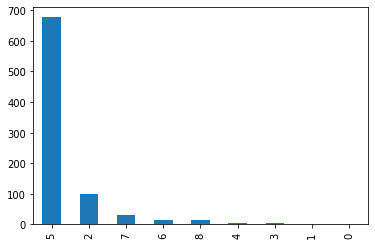

In [15]:
pd.Series(train_y).value_counts().plot(kind = 'bar')

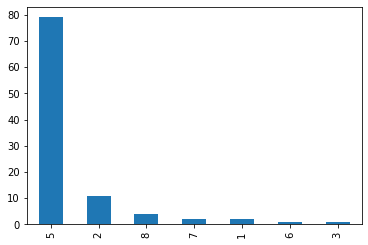

In [16]:
pd.Series(test_y).value_counts().plot(kind = 'bar')

**Extracting layer from pretrained bert model and adding a layer with softmax function to classify 20 classes of news.**

In [40]:
inputs = model.inputs[:2]
dense = model.get_layer('NSP-Dense').output
outputs = keras.layers.Dense(units=9, activation='softmax')(dense)

model = keras.models.Model(inputs, outputs)
model.compile(
  RAdam(learning_rate =LR),
  loss='sparse_categorical_crossentropy',
  metrics=['sparse_categorical_accuracy'],
)


**Initializing variables.**

In [41]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)


**Finally, training the model.**

In [46]:
# @title Fit

model.fit(
    train_x,
    train_y,
    epochs=15,
    batch_size=10,validation_data=(test_x, test_y),class_weight= np.array([88.44444444,44.22222222, 1.00505051, 17.68888889 ,17.68888889,  0.000001,  7.37037037,  2.85304659,  5.20261438])
)

Train on 850 samples, validate on 100 samples
Epoch 1/15
850/850 [==============================] - 19s 23ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9541 - val_loss: 1.0561 - val_sparse_categorical_accuracy: 0.8000
Epoch 2/15
850/850 [==============================] - 19s 23ms/step - loss: 0.0553 - sparse_categorical_accuracy: 0.9882 - val_loss: 1.3423 - val_sparse_categorical_accuracy: 0.6600
Epoch 3/15
850/850 [==============================] - 19s 23ms/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9871 - val_loss: 1.3539 - val_sparse_categorical_accuracy: 0.7900
Epoch 4/15
850/850 [==============================] - 19s 23ms/step - loss: 0.0714 - sparse_categorical_accuracy: 0.9835 - val_loss: 1.1086 - val_sparse_categorical_accuracy: 0.7000
Epoch 5/15
850/850 [==============================] - 19s 23ms/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9929 - val_loss: 1.3161 - val_sparse_categorical_accuracy: 0.7300
Epoch 6/15
850/850 [========================

**Making prediction for test dataset.**

In [47]:
model.save_weights('asdf.h5')
model.save('asd2f.h5')

predicts = model.predict(test_x, verbose=True).argmax(axis=-1)


100/100 [==============================] - 5s 50ms/step


**Calculating accuracy.**

In [49]:
print(test_y,'\n',predicts)
print(np.sum(test_y == predicts) / test_y.shape[0])

[5 5 5 5 5 5 5 5 2 5 5 5 5 8 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 8 5 5 5
 5 5 5 5 5 2 5 2 5 5 7 5 8 5 5 5 5 5 5 2 5 6 5 8 5 5 5 5 5 2 2 5 5 1 2 5 5
 7 2 5 5 5 5 2 5 5 5 5 5 5 5 2 1 5 5 5 5 5 5 2 5 5 5] 
 [5 5 5 5 5 5 5 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 5 5 2 2 8 2 5 5
 5 5 5 5 5 5 5 2 5 5 5 5 2 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 2 2 2 5 5 5 5 5 5
 5 5 5 5 5 5 2 5 5 5 5 5 8 2 5 2 2 5 5 5 5 5 5 5 5 5]
0.74


**Inference**

In [23]:

test_text = """The Mumbai batsman is set to replace underperforming KL Rahul as an opener in upcoming Test series against South Africa in home conditions.India’s newly-appointed batting coach Vikram Rathour feels opener Rohit Sharma is “too good a player” to not be playing in all three formats. Rathour, like many former cricketers, backed Rohit to open for India in Test cricket.“He is too good a player to not be playing in any game. That is what is everyone is thinking. He has done so well in white-ball cricket as an opener so there is no reason why he can’t succeed as a Test opener provided he gets enough opportunities,” Rathour believes Rohit can be an asset to his team if he does good against South Africa in Tests."""
test = """Senate Democrats are planning to hold the floor on Tuesday evening for an hours-long talk-a-thon on the issue of gun violence.The floor marathon comes as the White House is struggling to find a place to land in the weeks-long debate over potential gun-law reforms.“Many of my colleagues have seen their communities torn apart by gun violence; some by horrific mass shootings, others by a relentless, daily stream. Many of them have worked for years to bring commonsense gun safety measures before the Senate,” Senate Minority Leader Charles Schumer (D-N.Y.) said Tuesday, in announcing the plan from the Senate floor."""
ids, segments = tokenizer.encode(test, max_len=SEQ_LEN)

In [24]:
inpu = np.array(ids).reshape([1, SEQ_LEN])
get_label(model.predict([inpu,np.zeros_like(inpu)]).argmax(axis=-1)[0])


'Detective and Mystery'

In [25]:
ids, segments = tokenizer.encode(test_text, max_len=SEQ_LEN)
inpu = np.array(ids).reshape([1, SEQ_LEN])
get_label(model.predict([inpu,np.zeros_like(inpu)]).argmax(axis=-1)[0])

'Literary'